In [106]:
# imports:
import pandas as pd
from sklearn.cluster import KMeans
import pickle
pazak = {0:'Pazak',1:'Chatlanin'}

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

In [2]:
# Load euclidean distances data
df = pd.read_csv('Data/faces_euclidean_features.csv')
df.head()

,left_eye-right_eye,left_eye-nose,left_eye-mouth_left,left_eye-mouth_right,right_eye-left_eye,right_eye-nose,right_eye-mouth_left,right_eye-mouth_right,nose-left_eye,nose-right_eye,nose-mouth_left,nose-mouth_right,mouth_left-left_eye,mouth_left-right_eye,mouth_left-nose,mouth_left-mouth_right,mouth_right-left_eye,mouth_right-right_eye,mouth_right-nose,mouth_right-mouth_left
0,0.436686,0.293929,0.395205,0.534884,0.436686,0.414687,0.623971,0.396065,0.293929,0.414687,0.209624,0.274371,0.395205,0.623971,0.209624,0.414936,0.534884,0.396065,0.274371,0.414936
1,0.456806,0.315478,0.393492,0.565061,0.456806,0.306828,0.578675,0.385199,0.315478,0.306828,0.271917,0.249626,0.393492,0.578675,0.271917,0.384240,0.565061,0.385199,0.249626,0.384240
2,0.322055,0.361824,0.398738,0.552498,0.322055,0.132640,0.432794,0.386573,0.361824,0.132640,0.332479,0.254903,0.398738,0.432794,0.332479,0.285892,0.552498,0.386573,0.254903,0.285892
3,0.460852,0.304153,0.346807,0.524620,0.460852,0.320136,0.588235,0.354559,0.304153,0.320136,0.270767,0.221016,0.346807,0.588235,0.270767,0.407139,0.524620,0.354559,0.221016,0.407139
4,0.458330,0.338282,0.357675,0.570839,0.458330,0.268791,0.537670,0.352675,0.338282,0.268791,0.271729,0.233396,0.357675,0.537670,0.271729,0.395606,0.570839,0.352675,0.233396,0.395606


In [25]:
model = KMeans(n_clusters=2, random_state=42).fit(df)

In [47]:
with open("pazak.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

In [54]:
pazak[model.predict([df.iloc[11]])[0]]

'Chatlanin'

In [29]:
# Add k-Means predicted class to the dataframe
df['predictor'] = model.predict(df)

In [45]:
df['predictor'].value_counts(normalize=True)

0    0.778521
1    0.221479
Name: predictor, dtype: float64

In [79]:
# Analyze class imbalance in the targets:
weight_for_0 = 1.0 / df['predictor'].value_counts(normalize=True)[0] # Pazaks
weight_for_1 = 1.0 / df['predictor'].value_counts(normalize=True)[1] # Chatlanins

In [162]:
# Building a binary classification model:
def create_model(input_shape=20,neurons = 100):
    model = Sequential()
    model.add(Dense(neurons,input_shape=(input_shape,),activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(neurons,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(neurons,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[AUC()])
    return model

In [160]:
model1 = create_model(input_shape=len(df.columns)-1,neurons=100)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 100)               2100      
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 dense_79 (Dense)            (None, 100)               10100     
                                                                 
 dropout_40 (Dropout)        (None, 100)               0         
                                                                 
 dense_80 (Dense)            (None, 100)               10100     
                                                                 
 dropout_41 (Dropout)        (None, 100)               0         
                                                                 
 dense_81 (Dense)            (None, 1)               

In [62]:
X = df.drop(['predictor'],axis=1)
y = df['predictor']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [161]:
# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
#es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=100)
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#mc = ModelCheckpoint('best_model2.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4000, verbose=1, callbacks=[es, mc])

Epoch 1/4000


TypeError: in user code:

    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\training.py", line 998, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\engine\compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\metrics\__init__.py", line 181, in get
        return deserialize(str(identifier))
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\metrics\__init__.py", line 136, in deserialize
        return deserialize_keras_object(
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\utils\generic_utils.py", line 780, in deserialize_keras_object
        return obj()
    File "C:\Users\kerts\Documents\Projects\Python\PazakDetector\venv\lib\site-packages\keras\dtensor\utils.py", line 144, in _wrap_function
        init_method(instance, *args, **kwargs)

    TypeError: PrecisionAtRecall.__init__() missing 1 required positional argument: 'recall'


In [163]:
# load the saved model
saved_model = load_model('best_model1.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.999, Test: 0.999


Train: 0.999, Test: 0.999


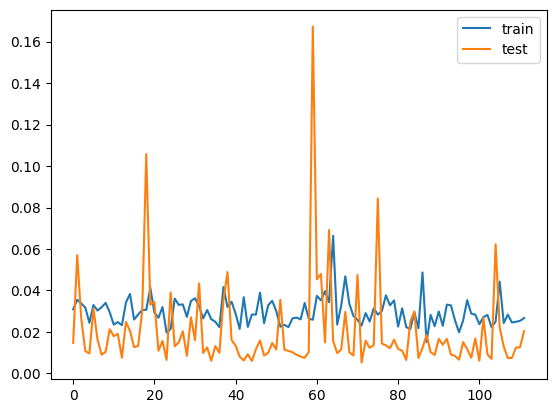

In [164]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [165]:
y_pred = saved_model.predict(X)
y_pred = (y_pred>0.5) #sigmoid

211/211 [==============================] - 0s 1ms/step


In [166]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y.values,y_pred)
print(cm)

[[5234    0]
 [   8 1481]]
